In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from joblib import Parallel, delayed

In [2]:
# Load data
notebook = "real1_Abalone_init"
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)
n_runs = experiment_results['metadata'].item()['n_runs']

In [3]:
def process_run(run_id, default_sigmas_data, mtmh_sigmas_data):
    """Process a single run for change point detection"""
    # Get sigma data for this specific run
    default_sigmas = default_sigmas_data[run_id]
    mtmh_sigmas = mtmh_sigmas_data[run_id]
    
    # Change point detection using Dynp algorithm
    model_default = rpt.Binseg(model="linear").fit(default_sigmas.reshape(-1, 1))
    default_changepoints = model_default.predict(n_bkps=1)

    model_mtmh = rpt.Binseg(model="linear").fit(mtmh_sigmas.reshape(-1, 1))
    mtmh_changepoints = model_mtmh.predict(n_bkps=1)
    
    return {
        'run_id': run_id,
        'default_sigmas': default_sigmas,
        'mtmh_sigmas': mtmh_sigmas,
        'default_changepoints': default_changepoints,
        'mtmh_changepoints': mtmh_changepoints
    }

In [4]:
# Extract sigma data arrays before parallel processing
default_sigmas_data = experiment_results['default'].item()['sigmas']
mtmh_sigmas_data = experiment_results['mtmh'].item()['sigmas']

# Parallel processing of all runs
results = Parallel(n_jobs=n_runs)(
    delayed(process_run)(run_id, default_sigmas_data, mtmh_sigmas_data) 
    for run_id in range(n_runs)
)

Run 0:
  Default BART change points: [35]
  MTMH BART change points: [8515]
Run 1:
  Default BART change points: [3665]
  MTMH BART change points: [1370]
Run 2:
  Default BART change points: [5840]
  MTMH BART change points: [1555]
Run 3:
  Default BART change points: [1025]
  MTMH BART change points: [80]
Run 4:
  Default BART change points: [8950]
  MTMH BART change points: [1590]


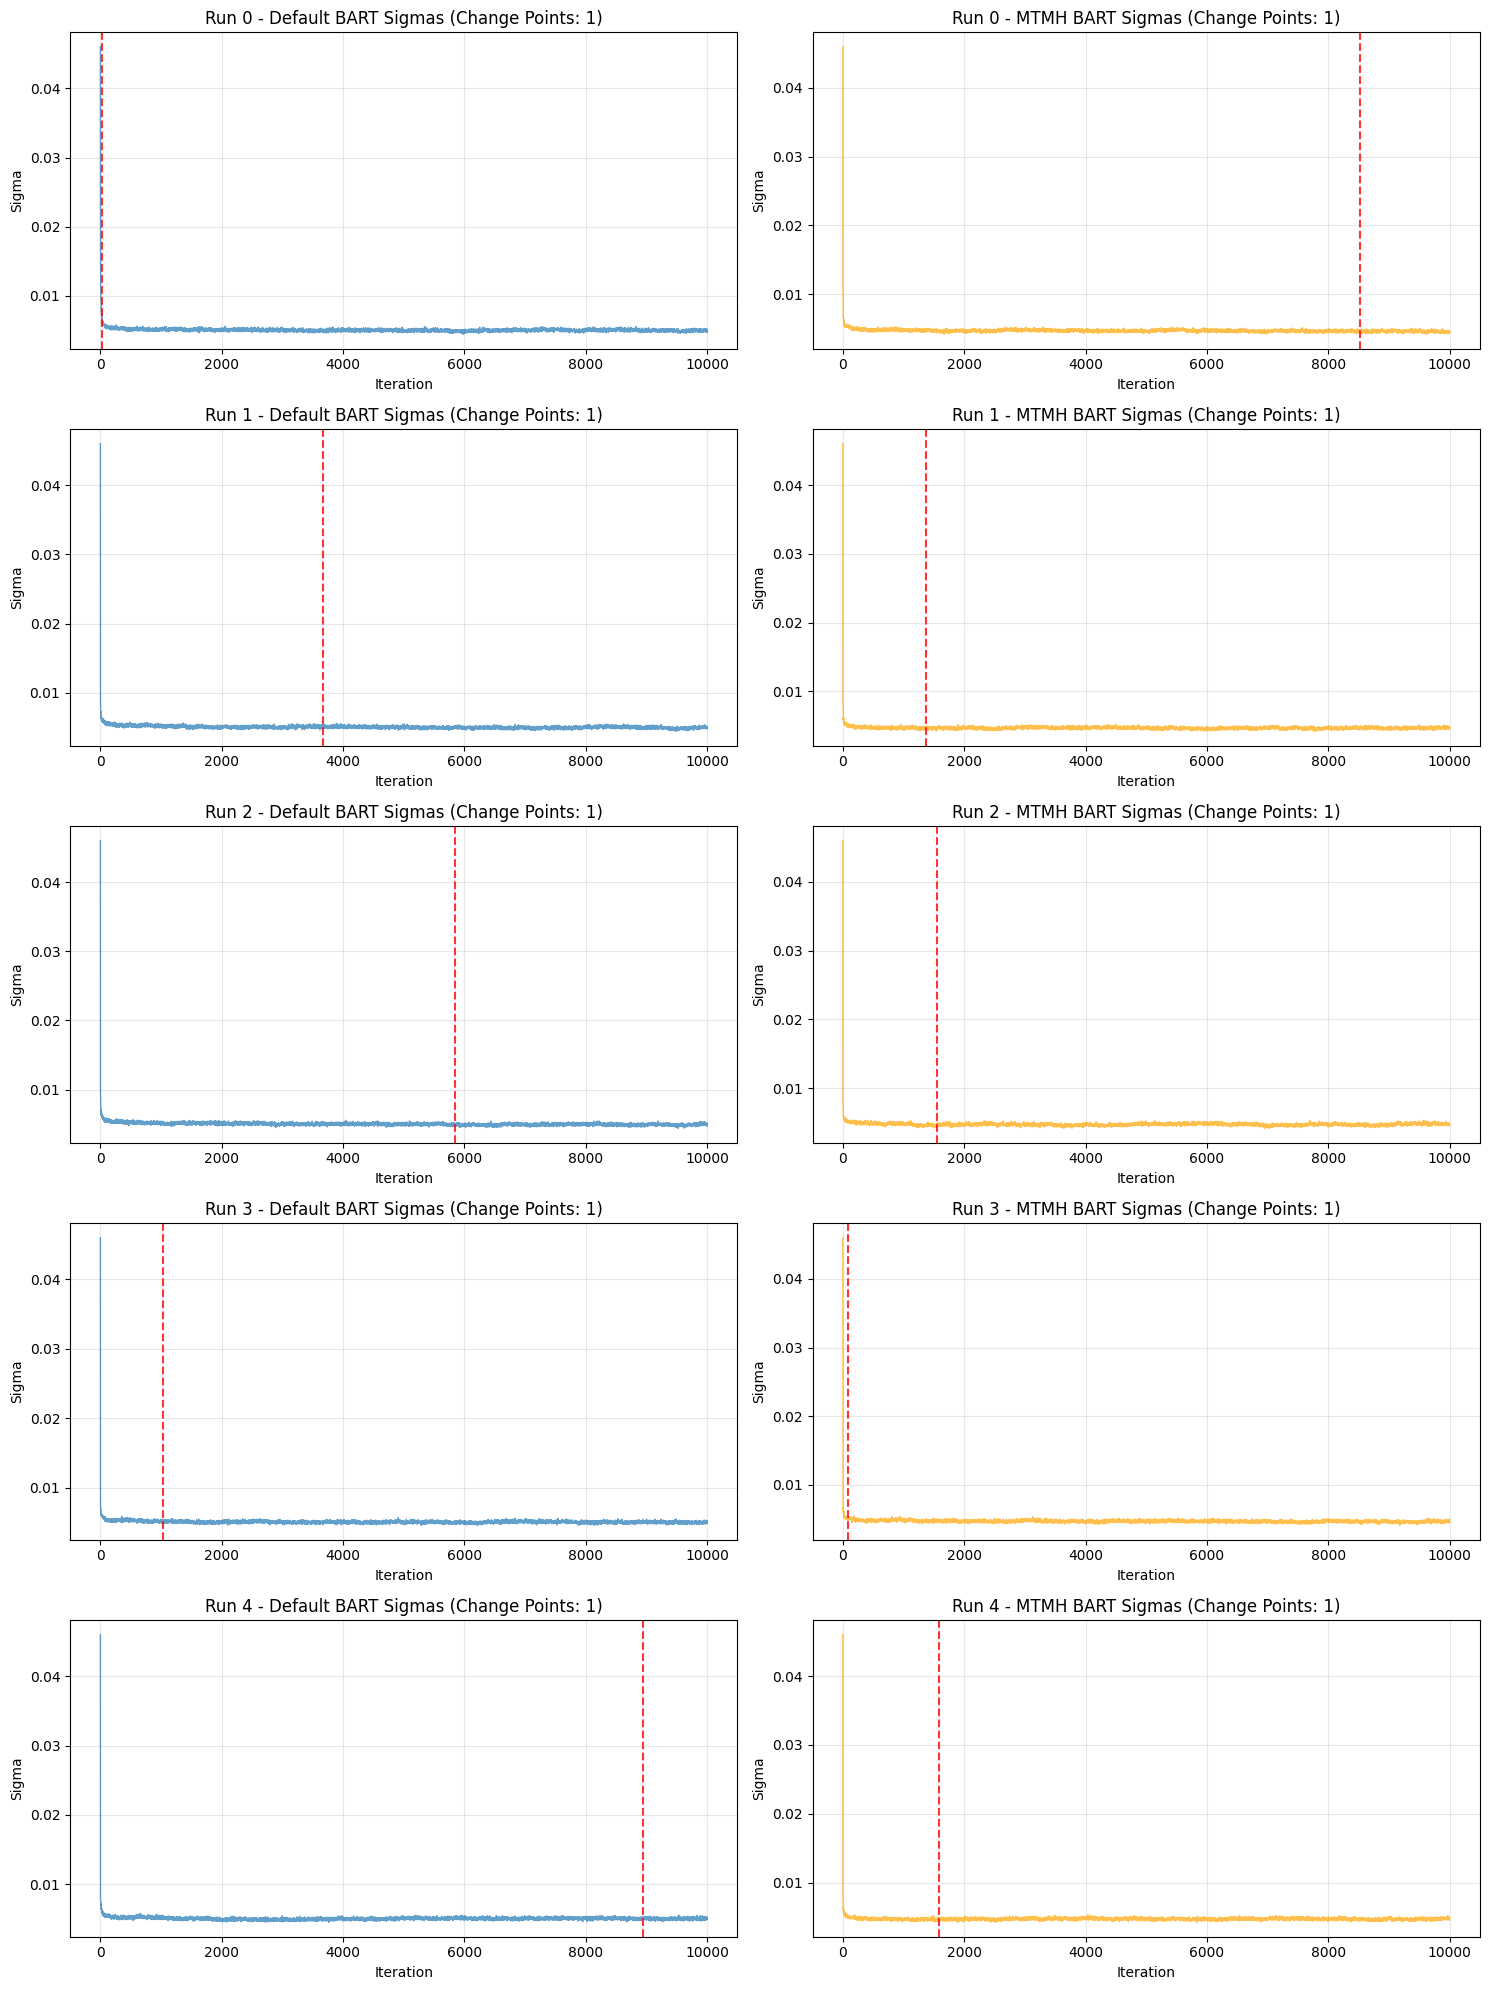

In [5]:
# Create subplots for visualization
fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

# Plot results
for result in results:
    run_id = result['run_id']
    
    # Plot Default BART
    axes[run_id, 0].plot(result['default_sigmas'], alpha=0.7, linewidth=1)
    for cp in result['default_changepoints'][:-1]:
        axes[run_id, 0].axvline(cp, color='red', linestyle='--', alpha=0.8)
    axes[run_id, 0].set_title(f'Run {run_id} - Default BART Sigmas (Change Points: {len(result["default_changepoints"])-1})')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigma')
    axes[run_id, 0].grid(True, alpha=0.3)
    
    # Plot MTMH BART
    axes[run_id, 1].plot(result['mtmh_sigmas'], alpha=0.7, linewidth=1, color='orange')
    for cp in result['mtmh_changepoints'][:-1]:
        axes[run_id, 1].axvline(cp, color='red', linestyle='--', alpha=0.8)
    axes[run_id, 1].set_title(f'Run {run_id} - MTMH BART Sigmas (Change Points: {len(result["mtmh_changepoints"])-1})')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Sigma')
    axes[run_id, 1].grid(True, alpha=0.3)
    
    # Print change point information
    print(f"Run {run_id}:")
    print(f"  Default BART change points: {result['default_changepoints'][:-1]}")
    print(f"  MTMH BART change points: {result['mtmh_changepoints'][:-1]}")

plt.tight_layout()
plt.show()